<a href="https://colab.research.google.com/github/jtmonroe/FreeCodeCamp-Dog-Cat/blob/main/fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We ought to remove `ImageDataGenerator` since it is deprcated in the API. We can replace it with `image_dataset_from_directory` as per

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, \
  Dense, Conv2D, Flatten, Dropout, MaxPooling2D, \
  Rescaling, Resizing, RandomFlip, RandomRotation, \
  RandomZoom, RandomSharpness, RandomContrast
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory


import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [33]:
# 3
def from_directory(directory, labels):
  return image_dataset_from_directory(directory, labels, label_mode='binary', image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=batch_size)

train_image_generator = from_directory(train_dir, labels='inferred')
validation_image_generator = from_directory(validation_dir, labels='inferred')
test_image_generator = from_directory(test_dir, labels=None)

train_data_gen = iter(train_image_generator)
val_data_gen = iter(validation_image_generator)
test_data_gen = iter(test_image_generator)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 50 files.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


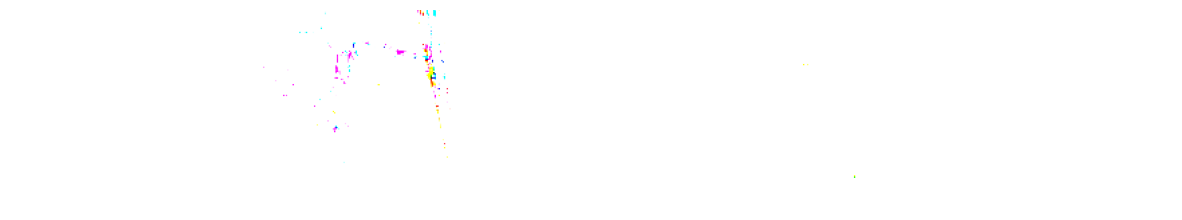

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(len(images_arr) * 3, 5))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [5]:
# 5 Doing this with Layers instead
# train_image_generator = train_image_generator.interleave(lambda x: x, cycle_length=10)


Found 2000 files belonging to 2 classes.


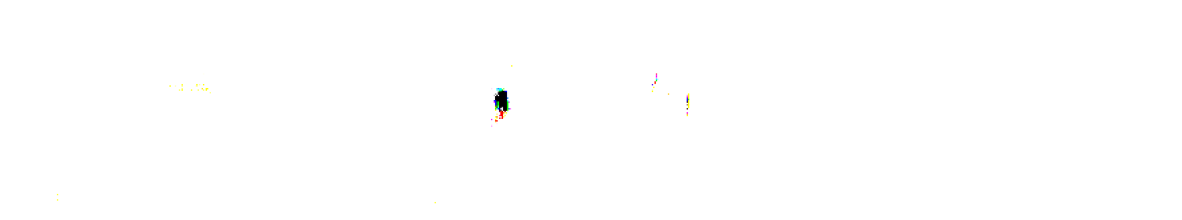

In [6]:
# 6
grayscale_images = image_dataset_from_directory(train_dir, labels='inferred', image_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='rgb')
augmented_images = [x[0][0] for x in grayscale_images.take(5)]
plotImages(augmented_images)

In [36]:
# 7
data_mutation = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH),
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.3),
    RandomContrast(0.4),
    RandomSharpness(0.6),
])

#   Dense, Conv2D, Flatten, Dropout, MaxPooling2D, \
#   Rescaling, Resizing, RandomFlip, RandomRotation, \
#   RandomZoom, RandomSharpness, RandomContrast

model = Sequential([
  InputLayer(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  data_mutation,
  Conv2D(5, 5, activation='relu'),
  Dropout(0.03),
  MaxPooling2D(),
  Conv2D(25, 5, activation='relu'),
  Dropout(0.03),
  MaxPooling2D(),
  Conv2D(50, 5, activation='relu'),
  MaxPooling2D(),
  Dense(125, activation='relu'),
  Flatten(),
  Dense(1)
])

model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_20 (Sequential)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 146, 146, 5)         │             380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 146, 146, 5)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 73, 73, 5)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 69, 69, 25)          │           3,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 69, 69, 25)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 34, 34, 25)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 30, 30, 50)          │          31,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 15, 15, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 15, 15, 125)         │           6,375 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 28125)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │          28,126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,331 (270.82 KB)

 Trainable params: 69,331 (270.82 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# 8
model.compile(loss='binary_crossentropy', metrics = ['accuracy'])
history = model.fit(train_image_generator, validation_data=validation_image_generator, epochs=epochs)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.4810 - loss: 6.8114 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 0.5034 - loss: 7.9163 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.4672 - loss: 8.4947 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.5006 - loss: 7.9611 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.5011 - loss: 7.9536 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.5104 - loss: 7.8059 - val_accuracy: 0.5000 - val_loss: 7.9712
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.4820 - 

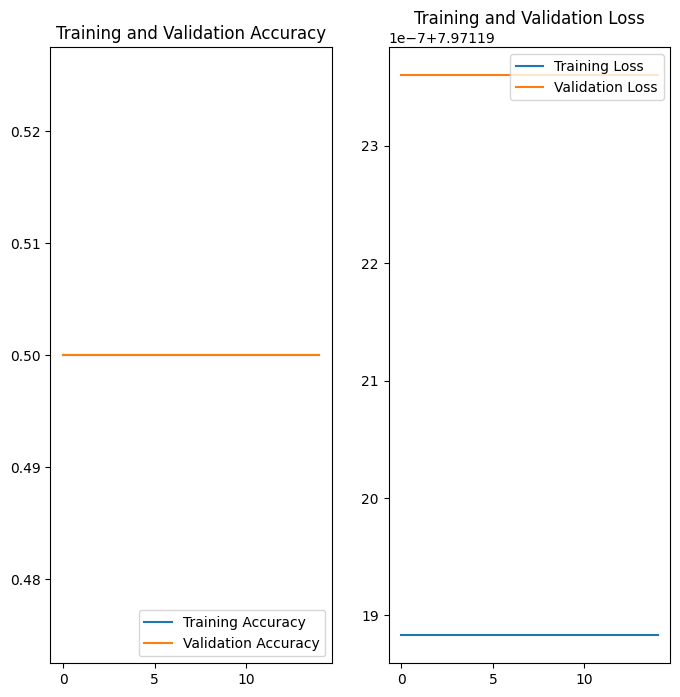

In [11]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

NameError: name 'probabilities' is not defined